## Mridangam stroke type classification task using Essentia Music Extractor.

In [73]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install git+https://github.com/mir-dataset-loaders/mirdata.git

  Cloning https://github.com/mir-dataset-loaders/mirdata.git to /tmp/pip-req-build-51hgtoif
  Running command git clone -q https://github.com/mir-dataset-loaders/mirdata.git /tmp/pip-req-build-51hgtoif
  Created wheel for mirdata: filename=mirdata-0.3.0b0-cp36-none-any.whl size=3004713 sha256=b40e6883d822b2323c1a63005170e248bfbb8b7ceeee264ac0341921f0491ca0
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jsjhq2t/wheels/6e/be/8a/52b3da4d137c6ae533897cdb2388a94692113ce1b72a7f22af
Successfully built mirdata


In [74]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as es
import pandas as pd

#Import Mridangam Stroke Dataset
mridangam_stroke = mirdata.Dataset('mridangam_stroke')


In [75]:
#This cell downloads and validates the mridangam dataset
mridangam_stroke.download()  # download the dataset
mridangam_stroke.validate()  # validate that all the expected files are there

0.00B [00:00, ?B/s]

Starting to download ['remote_data'] to folder /root/mir_datasets/mridangam_stroke
> downloading remote_data


124MB [00:23, 5.56MB/s]                           
100%|██████████| 6976/6976 [00:00<00:00, 9426.23it/s]

Success: the dataset is complete and all files are valid.
--------------------


({}, {})

In [76]:
mridangam_ids = mridangam_stroke.track_ids  # Load Mridangam IDs
mridangam_data = mridangam_stroke.load_tracks()  # Load Mridangam data

# Get complete list of different strokes
stroke_names = []
for i in mridangam_ids:
    stroke_names.append(mridangam_data[i].stroke_name)
stroke_names = np.unique(stroke_names)

print(stroke_names)

['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']


In [77]:
# You can create a dictionary using stroke type as keys
stroke_dict = {item: [] for item in stroke_names}
for i in mridangam_ids:
    stroke_dict[mridangam_data[i].stroke_name].append(mridangam_data[i].audio_path)

stroke_dict

{'bheem': ['/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224030__akshaylaya__bheem-b-001.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224031__akshaylaya__bheem-b-002.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224032__akshaylaya__bheem-b-003.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224033__akshaylaya__bheem-b-004.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224034__akshaylaya__bheem-b-005.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/C/225356__akshaylaya__bheem-c-001.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/C/225357__akshaylaya__bheem-c-002.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/C/225358__akshaylaya__bheem-c-003.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/C#/226488__akshaylaya__bheem-csh-001.wav',
  '/root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/D#/228625__akshaylaya__bheem

In [79]:
list(stroke_dict)  # List the stroke type from dict

['bheem', 'cha', 'dheem', 'dhin', 'num', 'ta', 'tha', 'tham', 'thi', 'thom']

Plot waveforms of random samples of each stroke type...


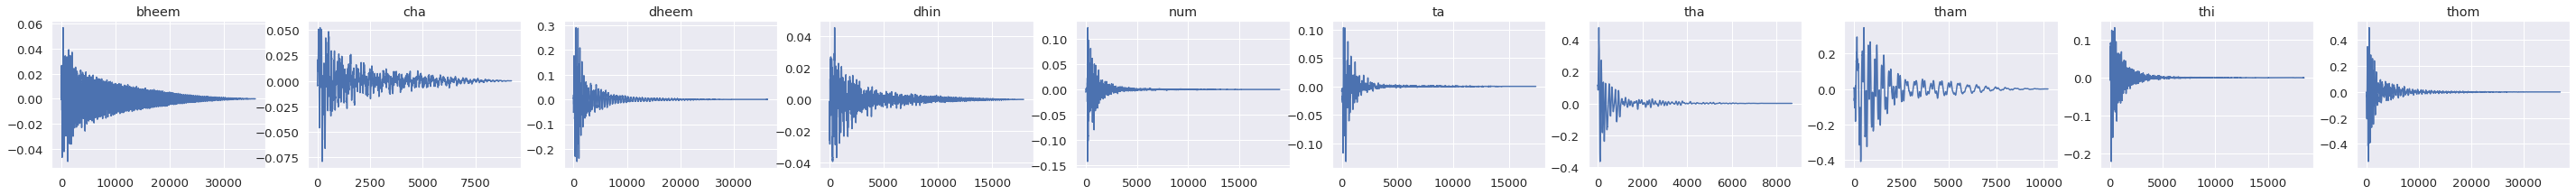

In [80]:
# Raw-data preprocess analysis parameters
_, fs = mridangam_data[mridangam_ids[0]].audio

num_strokes = len(stroke_dict.keys())
print("Plot waveforms of random samples of each stroke type...")
plt.figure(1, figsize=(5 * num_strokes, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, stroke in enumerate(stroke_dict.keys()):
    sample_file = stroke_dict[stroke][file_ind_inlist]
    x = es.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_strokes,(i+1))
    plt.plot(x)
    plt.title(stroke)

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [82]:
# Print descriptors to be considered
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [83]:
# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = '/root/mir_datasets/mridangam_stroke/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['stroke']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for i in mridangam_ids:
        file_count +=1
        if file_count % 20 == 0: #print name of a file every 20 files
            print(file_count, "files processed, current file: ", mridangam_data[i].audio_path)

        #Compute and write features for file
        features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(mridangam_data[i].audio_path)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = mridangam_data[i].stroke_name  # class information
        line2write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")

20 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224049__akshaylaya__cha-b-015.wav
40 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224070__akshaylaya__cha-b-036.wav
60 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224091__akshaylaya__cha-b-057.wav
80 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224113__akshaylaya__dheem-b-022.wav
100 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224133__akshaylaya__dheem-b-042.wav
120 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224153__akshaylaya__dheem-b-062.wav
140 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224174__akshaylaya__dheem-b-083.wav
160 files processed, current file:  /root/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/

In [84]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,stroke
0,0.990684,14.912681,1.874190,0.381473,0.079946,206.729431,143.392395,9.318307,3.896551,1.734256,3.106031,0.390342,0.035999,11.047028,24.315882,6.609258,0.261659,0.055245,35.515007,36.043941,4.700181,2.828996,12.899049,11.292480,2.738937,5.070402,-44.772682,0.0,-49.626934,6.795559,-48.755653,0.0,22.470417,2.159062,0.519941,0.090874,139.229782,94.011238,5.883671,2.201923,...,0.0,1.000000,0.000000,0.472222,0.499228,178.660294,83.102608,2.583333,3.639102,-3.641916e-09,5.585160e-09,0.013994,0.021512,0.000008,0.000030,0.011997,0.017472,0.000289,0.000919,0.006240,0.010109,5.110149,0.897209,0.023242,0.046308,26.738409,10.206458,0.002702,0.002520,178.845215,92.314140,4.329944,0.907357,3846075.50,1821880.75,0.466391,0.427255,0.009752,0.003432,bheem
1,0.990684,15.142743,1.681169,0.402627,0.082421,164.644791,104.370613,7.042668,2.472328,1.288791,2.646105,0.391095,0.027835,4.722796,24.913254,6.307956,0.285930,0.054497,38.575294,29.304688,5.125165,2.565615,9.075223,7.798732,3.684739,4.880339,-42.476761,0.0,-43.706135,3.389843,-48.305824,0.0,22.060148,2.602911,0.542205,0.091746,109.818726,60.655712,4.758379,1.404089,...,0.0,0.958333,0.199826,0.333333,0.471404,177.102646,98.768608,2.666667,3.171049,-5.896105e-09,7.120350e-09,0.022587,0.027306,0.000003,0.000005,0.020059,0.023513,0.000165,0.000409,0.009864,0.012464,4.904476,0.916866,0.033542,0.054421,34.154037,12.261000,0.003725,0.002857,176.751709,88.779144,4.886358,0.931026,3262975.75,2250954.00,0.649012,0.499143,0.007080,0.001101,bheem
2,0.990684,14.764849,1.969599,0.372774,0.074290,128.644562,85.417946,6.503448,2.328227,1.265119,1.449310,0.381030,0.041404,0.000000,22.968189,6.914976,0.262560,0.050239,25.080460,21.660767,4.118201,2.082314,12.259754,11.497897,4.659772,6.203113,-40.684090,0.0,-40.684090,0.000000,-49.434700,0.0,21.310865,3.374161,0.507870,0.082047,116.137001,62.524059,5.429476,1.717700,...,0.0,1.000000,0.000000,0.312500,0.463512,177.981201,66.472427,2.625000,2.869560,-6.398069e-09,6.852936e-09,0.024570,0.026396,0.000009,0.000025,0.019949,0.019908,0.000222,0.000482,0.011669,0.014046,5.235641,0.83

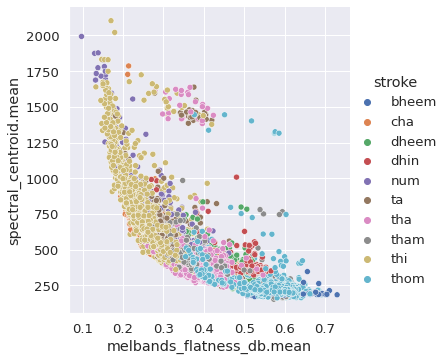

In [85]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "stroke", data = data);

### Preprocessing of the features


In [88]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [89]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.stroke.value_counts()

thi      2164
tha      1151
ta        923
thom      616
num       482
dhin      466
dheem     449
tham      357
cha       319
bheem      49
Name: stroke, dtype: int64

In [90]:
# Here we didn't pick the lowest number, 49 for bheem, which is too small. Instead, we choose the 330 of "cha"
min_number = data_modif.stroke.value_counts()['cha']
thi_data = data_modif[data_modif.stroke == 'thi'].sample(n = min_number, random_state = 42)
tha_data = data_modif[data_modif.stroke == 'tha'].sample(n = min_number)
ta_data = data_modif[data_modif.stroke == 'ta'].sample(n = min_number)
thom_data = data_modif[data_modif.stroke == 'thom'].sample(n = min_number)
num_data = data_modif[data_modif.stroke == 'num'].sample(n = min_number)
dhin_data = data_modif[data_modif.stroke == 'dhin'].sample(n = min_number)
dheem_data = data_modif[data_modif.stroke == 'dheem'].sample(n = min_number)
tham_data = data_modif[data_modif.stroke == 'tham'].sample(n = min_number)
cha_data = data_modif[data_modif.stroke == 'cha'].sample(n = min_number)
bheem_data = data_modif[data_modif.stroke == 'bheem']
#Merging after downsampling
data_modif = pd.concat([thi_data, tha_data, ta_data, thom_data, num_data, dhin_data, dheem_data, tham_data, cha_data, bheem_data])
#Checking the balance again
data_modif.stroke.value_counts()

cha      319
dheem    319
dhin     319
thom     319
tha      319
tham     319
ta       319
thi      319
num      319
bheem     49
Name: stroke, dtype: int64

## Supervised learning approach (Support Vector Machines)

In [92]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.stroke = pd.Categorical(data_modif.stroke)  # convert to categorical data
y = np.array(data_modif.stroke.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [1.         0.41322657 0.49032454 0.16495979 0.14250878 0.00342302
 0.00225497 0.0867776  0.02434006 0.1416637  0.06997658 0.78783023
 0.08884944 0.         0.20226843 0.2922227  0.23966443 0.17863183
 0.00541523 0.00549548 0.07785213 0.07684346 0.28172228 0.13774242
 0.14221792 0.08838288 0.7737222  0.         0.84668    0.
 0.74097832 0.         0.31242355 0.22897442 0.26445104 0.16937784
 0.01111849 0.00184799 0.27315564 0.03006777 0.26608676 0.11230688
 0.6086137  0.45817762 1.         0.         1.         0.
 0.85809314 0.77138913 0.30054574 0.04230187 0.25079945 0.49194166
 0.81632901 0.13623372 0.18666474 0.13113275 0.17168251 0.08344706
 0.07107757 0.08847268 0.06774983 0.04273923 0.22996136 0.14660791
 0.80361648 0.12682383 0.36546962 0.50614404 0.04024435 0.0184649
 0.21665339 0.35615473 0.04241396 0.0337769  0.09748259 0.05600295
 0.16287732 0.08221434 0.0757309  0.04232196 0.08460428 0.03831936]
Class of the first sample:  8


In [93]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (1956, 84) , Size of train output vector:  (1956,)
Size of test features matrix:  (964, 84) , Size of test output vector:  (964,)


In [95]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [96]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,

In [97]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.8661825726141079


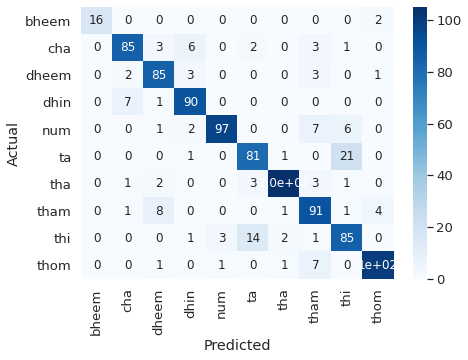

In [98]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.stroke)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Unsupervised learning approach (Neural Network)

In [99]:
# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [100]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (2336, 10)
One-hot encoded y_test shape =  (584, 10)


In [101]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 10))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [102]:
model.summary()  # Plot summary of the model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 84)                336       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 40)                3400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
_________________________________________________________________
activation_3 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 20)                820       
_________________________________________________________________
batch_normalization_3 (Batch (None, 20)               

In [103]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0,)

In [104]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.031867071986198425
Test accuracy: 0.9554794430732727


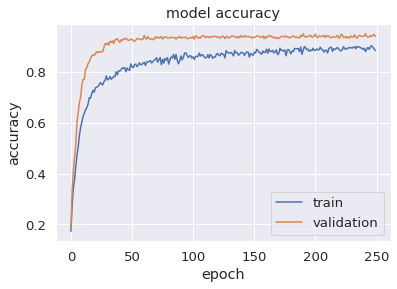

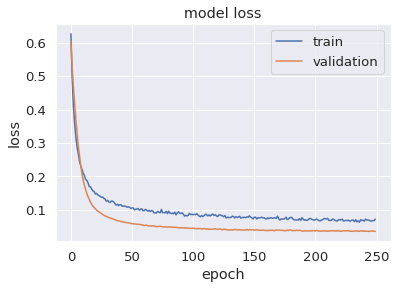

In [105]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()